# Composite Design Methodology and Carpet Plots

This notebook covers:
1. Carpet Plot Theory and Implementation
2. Composite Design Methodology
3. Case Study: Bike Fork Design

## 1. Carpet Plots

### 1.1 Theory

Carpet plots are powerful visualization tools for composite design that show how laminate properties vary with ply orientations and stacking sequences. They help designers:
- Visualize property trends
- Identify optimal layups
- Compare different material combinations
- Make quick design decisions

#### 1.1.1 Basic Carpet Plot

For a basic carpet plot, we typically use:
- X-axis: Percentage of 0° plies
- Y-axis: Percentage of ±45° plies
- Z-axis (color): Property of interest (e.g., Ex, Ey, Gxy)

The remaining percentage is automatically 90° plies:
$$P_{90} = 100\% - P_0 - P_{\pm45}$$

#### 1.1.2 Hybrid Composite Carpet Plots

For hybrid composites, we can create multi-dimensional carpet plots:
1. Material ratio plots:
   - X-axis: Percentage of material A
   - Y-axis: Percentage of 0° plies
   - Z-axis: Property of interest

2. Cost-performance plots:
   - X-axis: Cost per unit area
   - Y-axis: Performance metric
   - Color: Material combination

3. Weight-stiffness plots:
   - X-axis: Areal weight
   - Y-axis: Stiffness
   - Color: Material combination

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from custom_composite import CustomLayup, PlyProperties, MaterialType, create_layup_from_sequence

def create_carpet_plot(material: dict, property_name: str, n_points: int = 20):
    """Create a carpet plot for a given material and property"""
    # Create grid of ply percentages
    p0 = np.linspace(0, 100, n_points)  # 0° plies
    p45 = np.linspace(0, 100, n_points)  # ±45° plies
    P0, P45 = np.meshgrid(p0, p45)
    
    # Initialize property matrix
    property_matrix = np.zeros_like(P0)
    
    # Calculate properties for each point
    for i in range(n_points):
        for j in range(n_points):
            if P0[i,j] + P45[i,j] <= 100:  # Valid combination
                # Create layup
                n_plies = 20  # Total number of plies
                n0 = int(P0[i,j] * n_plies / 100)  # Number of 0° plies
                n45 = int(P45[i,j] * n_plies / 100)  # Number of ±45° plies
                n90 = n_plies - n0 - n45  # Number of 90° plies
                
                # Create sequence
                sequence = []
                sequence.extend([{'material_type': material, 'thickness': 0.1, 'orientation': 0}] * n0)
                sequence.extend([{'material_type': material, 'thickness': 0.1, 'orientation': 45}] * (n45//2))
                sequence.extend([{'material_type': material, 'thickness': 0.1, 'orientation': -45}] * (n45//2))
                sequence.extend([{'material_type': material, 'thickness': 0.1, 'orientation': 90}] * n90)
                
                # Calculate properties
                layup = create_layup_from_sequence(sequence)
                props = layup.calculate_effective_properties()
                property_matrix[i,j] = props[property_name]
            else:
                property_matrix[i,j] = np.nan
    
    return P0, P45, property_matrix

def plot_carpet(P0, P45, property_matrix, property_name: str, material_name: str):
    """Plot the carpet plot"""
    plt.figure(figsize=(10, 8))
    plt.contourf(P0, P45, property_matrix, levels=20, cmap='viridis')
    plt.colorbar(label=f'{property_name} (GPa)')
    plt.xlabel('Percentage of 0° plies')
    plt.ylabel('Percentage of ±45° plies')
    plt.title(f'{property_name} Carpet Plot for {material_name}')
    
    # Add contour lines
    CS = plt.contour(P0, P45, property_matrix, colors='k', alpha=0.5)
    plt.clabel(CS, inline=True, fontsize=8)
    
    # Add invalid region
    plt.fill_between([0, 100], [100, 0], [100, 100], color='gray', alpha=0.3, label='Invalid')
    plt.legend()
    plt.show()

def create_hybrid_carpet(material1: dict, material2: dict, property_name: str, n_points: int = 20):
    """Create a carpet plot for hybrid composites"""
    # Create grid of material ratios and ply percentages
    p_m1 = np.linspace(0, 100, n_points)  # Percentage of material 1
    p0 = np.linspace(0, 100, n_points)    # Percentage of 0° plies
    P_M1, P0 = np.meshgrid(p_m1, p0)
    
    # Initialize property matrix
    property_matrix = np.zeros_like(P_M1)
    cost_matrix = np.zeros_like(P_M1)
    
    # Calculate properties for each point
    for i in range(n_points):
        for j in range(n_points):
            if P0[i,j] <= 100:  # Valid combination
                # Create layup
                n_plies = 20
                n0 = int(P0[i,j] * n_plies / 100)
                n_m1 = int(P_M1[i,j] * n_plies / 100)
                
                # Create sequence
                sequence = []
                # Add material 1 plies
                sequence.extend([{'material_type': material1, 'thickness': 0.1, 'orientation': 0}] * n_m1)
                # Add material 2 plies
                sequence.extend([{'material_type': material2, 'thickness': 0.1, 'orientation': 0}] * (n_plies - n_m1))
                
                # Calculate properties
                layup = create_layup_from_sequence(sequence)
                props = layup.calculate_effective_properties()
                property_matrix[i,j] = props[property_name]
                
                # Calculate cost (example)
                cost_matrix[i,j] = (n_m1 * material1.get('cost', 0) + 
                                   (n_plies - n_m1) * material2.get('cost', 0)) / n_plies
            else:
                property_matrix[i,j] = np.nan
                cost_matrix[i,j] = np.nan
    
    return P_M1, P0, property_matrix, cost_matrix

### 1.2 Example Carpet Plots

Let's create some example carpet plots for different materials and properties:

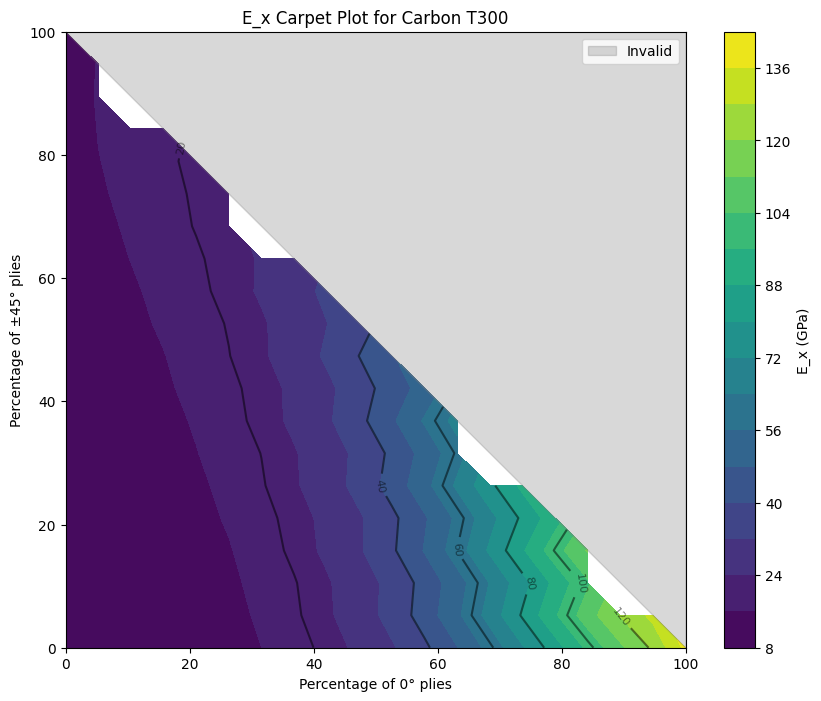

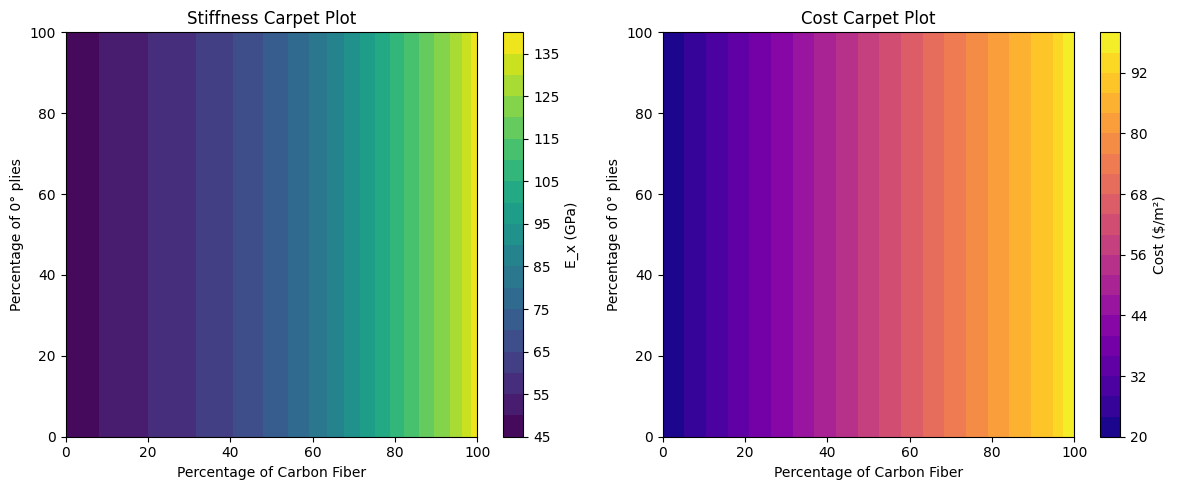

In [3]:
# Create carpet plot for carbon fiber
carbon = MaterialType.CARBON_T300.value
P0, P45, Ex_matrix = create_carpet_plot(carbon, 'E_x')
plot_carpet(P0, P45, Ex_matrix, 'E_x', 'Carbon T300')

# Create hybrid carpet plot
carbon['cost'] = 100  # $/m²
glass = MaterialType.GLASS_E.value
glass['cost'] = 20    # $/m²

P_M1, P0, Ex_matrix, cost_matrix = create_hybrid_carpet(carbon, glass, 'E_x')

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.contourf(P_M1, P0, Ex_matrix, levels=20, cmap='viridis')
plt.colorbar(label='E_x (GPa)')
plt.xlabel('Percentage of Carbon Fiber')
plt.ylabel('Percentage of 0° plies')
plt.title('Stiffness Carpet Plot')

plt.subplot(122)
plt.contourf(P_M1, P0, cost_matrix, levels=20, cmap='plasma')
plt.colorbar(label='Cost ($/m²)')
plt.xlabel('Percentage of Carbon Fiber')
plt.ylabel('Percentage of 0° plies')
plt.title('Cost Carpet Plot')

plt.tight_layout()
plt.show()

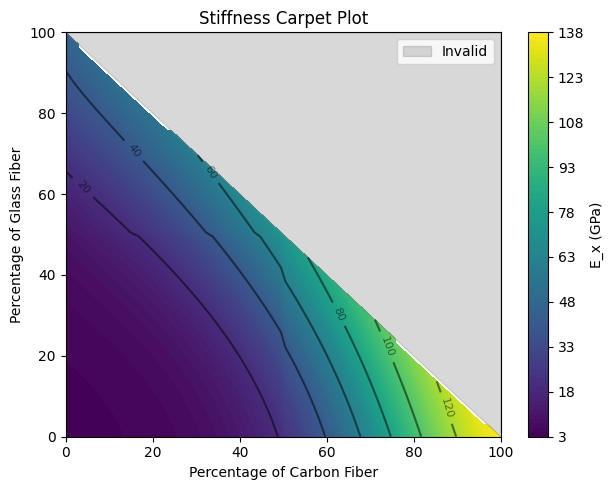

In [4]:

def create_hybrid_carpet_2(material1: dict, material2: dict, property_name: str, n_points: int = 20, n_plies: int = 20, cross=False):
    """Create a carpet plot for hybrid composites showing material ratios"""
    # Create grid of material percentages
    p_m1 = np.linspace(0, 100, n_points)  # Percentage of material 1
    p_m2 = np.linspace(0, 100, n_points)  # Percentage of material 2
    P_M1, P_M2 = np.meshgrid(p_m1, p_m2)
    
    # Call resin
    resin = MaterialType.resin.value 
    # Initialize property matrix
    property_matrix = np.zeros_like(P_M1)
    cost_matrix = np.zeros_like(P_M1)
    
    # Calculate properties for each point
    for i in range(n_points):
        for j in range(n_points):
            if P_M1[i,j] + P_M2[i,j] <= 100: #and P_M1[i,j] + P_M2[i,j] > 0:  # Valid combination
                # Create layup
                n_plies = n_plies
                n_m1 = round(P_M1[i,j] * n_plies / 100)
                n_m2 = round(P_M2[i,j] * n_plies / 100)
                n_resin = n_plies - n_m1 -n_m2  # ensures total is always n_plies
                
                # Create sequence with balanced orientation
                sequence = []
                # Add material 1 plies with balanced orientation
                if n_m1 > 0:
                    if cross:
                        n_m1_0 = n_m1 // 2
                        n_m1_90 = n_m1 - n_m1_0
                        sequence.extend([{'material_type': material1, 'thickness': 0.1, 'orientation': 0}] * n_m1_0)
                        sequence.extend([{'material_type': material1, 'thickness': 0.1, 'orientation': 90}] * n_m1_90)
                    else:
                        sequence.extend([{'material_type': material1, 'thickness': 0.1, 'orientation': 0}] * n_m1)
                
                # Add material 2 plies with balanced orientation
                if n_m2 > 0:
                    if cross:
                        n_m2_0 = n_m2 // 2
                        n_m2_90 = n_m2 - n_m2_0
                        sequence.extend([{'material_type': material2, 'thickness': 0.1, 'orientation': 0}] * n_m2_0)
                        sequence.extend([{'material_type': material2, 'thickness': 0.1, 'orientation': 90}] * n_m2_90)
                    else:
                        sequence.extend([{'material_type': material2, 'thickness': 0.1, 'orientation': 0}] * n_m2)

                # Add resin
                if n_resin > 0:
                    if cross:
                        n_resin_0 = n_resin // 2
                        n_resin_90 = n_resin - n_resin_0
                        sequence.extend([{'material_type': resin, 'thickness': 0.1, 'orientation': 0}] * n_resin_0)
                        sequence.extend([{'material_type': resin, 'thickness': 0.1, 'orientation': 90}] * n_resin_90)
                    else:
                        sequence.extend([{'material_type': resin, 'thickness': 0.1, 'orientation': 0}] * n_resin)
                   


                if len(sequence) == 0:
                    continue
                # Calculate properties
                layup = create_layup_from_sequence(sequence)
                props = layup.calculate_effective_properties()
                property_matrix[i,j] = props[property_name]
                
                # Calculate cost (example)
                cost_matrix[i,j] = (n_m1 * material1.get('cost', 0) + 
                                   n_m2 * material2.get('cost', 0)) / n_plies
            else:
                property_matrix[i,j] = np.nan
                cost_matrix[i,j] = np.nan
    
    return P_M1, P_M2, property_matrix, cost_matrix

# Example usage in the notebook:
# Create hybrid carpet plot
carbon = {**MaterialType.CARBON_T300.value, 'cost': 100}  # $/m²
glass = {**MaterialType.GLASS_E.value, 'cost': 20}    # $/m²

P_M1, P_M2, Ex_matrix, cost_matrix = create_hybrid_carpet_2(carbon, glass, 'E_x', n_points = 100, n_plies=100)
#P_M1, P_M2, Ey_matrix, cost_matrix = create_hybrid_carpet_2(carbon, glass, 'E_y', n_points = 100, n_plies=100)


plt.figure(figsize=(12, 5))

#E_x
plt.subplot(121)
plt.contourf(P_M1, P_M2, Ex_matrix, levels=100, cmap='viridis')
plt.colorbar(label='E_x (GPa)')
plt.xlabel('Percentage of Carbon Fiber')
plt.ylabel('Percentage of Glass Fiber')
plt.title('Stiffness Carpet Plot')
# Add contour lines
CS = plt.contour(P_M1, P_M2, Ex_matrix, colors='k', alpha=0.5)
plt.clabel(CS, inline=True, fontsize=8)
# Add invalid region
plt.fill_between([0, 100], [100, 0], [100, 100], color='gray', alpha=0.3, label='Invalid')
plt.legend()

#E_y
'''plt.subplot(122)
plt.contourf(P_M1, P_M2, Ey_matrix, levels=100, cmap='plasma')
plt.colorbar(label='E_y (GPa)')
plt.xlabel('Percentage of Carbon Fiber')
plt.ylabel('Percentage of Glass Fiber')
plt.title('Stiffness 2 Carpet Plot')
# Add contour lines
CS = plt.contour(P_M1, P_M2, Ey_matrix, colors='k', alpha=0.5)
plt.clabel(CS, inline=True, fontsize=8)
# Add invalid region
plt.fill_between([0, 100], [100, 0], [100, 100], color='gray', alpha=0.3, label='Invalid')
plt.legend()

#Cost

plt.subplot(123)
plt.contourf(P_M1, P_M2, cost_matrix, levels=100, cmap='plasma')
plt.colorbar(label='Cost ($/m²)')
plt.xlabel('Percentage of Carbon Fiber')
plt.ylabel('Percentage of Glass Fiber')
plt.title('Cost Carpet Plot')
# Add contour lines
CS = plt.contour(P_M1, P_M2, cost_matrix, colors='k', alpha=0.5)
plt.clabel(CS, inline=True, fontsize=8)
# Add invalid region
plt.fill_between([0, 100], [100, 0], [100, 100], color='gray', alpha=0.3, label='Invalid')
plt.legend()'''

plt.tight_layout()
plt.show()



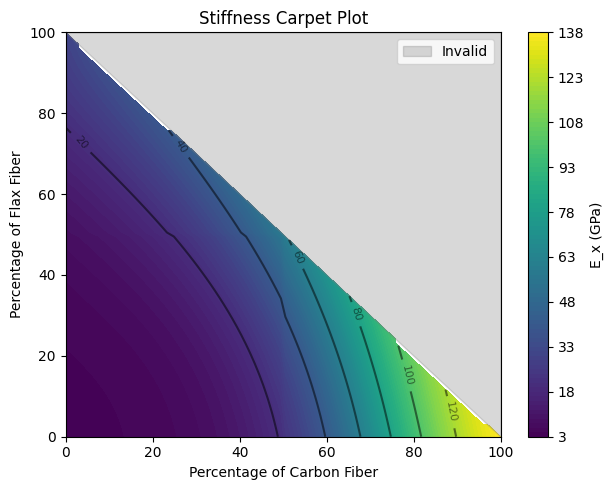

In [5]:

# Example usage in the notebook:
# Create hybrid carpet plot
carbon = {**MaterialType.CARBON_T300.value, 'cost': 100}  # $/m²
flax = {**MaterialType.Flax_generic.value, 'cost': 20}    # $/m²

P_M1, P_M2, Ex_matrix, cost_matrix = create_hybrid_carpet_2(carbon, flax, 'E_x', n_points = 100, n_plies=100)
#P_M1, P_M2, Ey_matrix, cost_matrix = create_hybrid_carpet_2(carbon, glass, 'E_y', n_points = 100, n_plies=100)


plt.figure(figsize=(12, 5))

#E_x
plt.subplot(121)
plt.contourf(P_M1, P_M2, Ex_matrix, levels=100, cmap='viridis')
plt.colorbar(label='E_x (GPa)')
plt.xlabel('Percentage of Carbon Fiber')
plt.ylabel('Percentage of Flax Fiber')
plt.title('Stiffness Carpet Plot')
# Add contour lines
CS = plt.contour(P_M1, P_M2, Ex_matrix, colors='k', alpha=0.5)
plt.clabel(CS, inline=True, fontsize=8)
# Add invalid region
plt.fill_between([0, 100], [100, 0], [100, 100], color='gray', alpha=0.3, label='Invalid')
plt.legend()

#E_y
'''plt.subplot(122)
plt.contourf(P_M1, P_M2, Ey_matrix, levels=100, cmap='plasma')
plt.colorbar(label='E_y (GPa)')
plt.xlabel('Percentage of Carbon Fiber')
plt.ylabel('Percentage of Glass Fiber')
plt.title('Stiffness 2 Carpet Plot')
# Add contour lines
CS = plt.contour(P_M1, P_M2, Ey_matrix, colors='k', alpha=0.5)
plt.clabel(CS, inline=True, fontsize=8)
# Add invalid region
plt.fill_between([0, 100], [100, 0], [100, 100], color='gray', alpha=0.3, label='Invalid')
plt.legend()

#Cost

plt.subplot(123)
plt.contourf(P_M1, P_M2, cost_matrix, levels=100, cmap='plasma')
plt.colorbar(label='Cost ($/m²)')
plt.xlabel('Percentage of Carbon Fiber')
plt.ylabel('Percentage of Glass Fiber')
plt.title('Cost Carpet Plot')
# Add contour lines
CS = plt.contour(P_M1, P_M2, cost_matrix, colors='k', alpha=0.5)
plt.clabel(CS, inline=True, fontsize=8)
# Add invalid region
plt.fill_between([0, 100], [100, 0], [100, 100], color='gray', alpha=0.3, label='Invalid')
plt.legend()'''

plt.tight_layout()
plt.show()


## 2. Composite Design Methodology

### 2.1 Conceptual Design

The conceptual design phase focuses on understanding the basic requirements and constraints:

1. Load Analysis:
   - Identify primary loads
   - Determine load paths
   - Calculate required stiffness

2. Material Selection:
   - Consider available materials
   - Evaluate cost constraints
   - Check manufacturing feasibility

3. Initial Layup Selection:
   - Use carpet plots to identify promising regions
   - Consider basic ply orientations (0°, ±45°, 90°)
   - Estimate required thickness

### 2.2 Preliminary Design

The preliminary design phase uses carpet plots and basic analysis to narrow down options:

1. Stiffness-Based Design:
   - Use carpet plots to find layups meeting stiffness requirements
   - Consider different material combinations
   - Calculate minimum thickness for each constraint

2. Strength-Based Design:
   - Apply strain allowables
   - Calculate strength ratios
   - Determine critical load cases

3. Cost and Weight Optimization:
   - Create cost-performance carpet plots
   - Evaluate weight implications
   - Consider manufacturing costs

4. Constraint Analysis:
   - Create constraint diagram
   - Plot thickness vs. property for each constraint
   - Identify feasible design space

### 2.3 Detailed Design

The detailed design phase uses full laminate theory for final optimization:

1. Failure Analysis:
   - Apply multiple failure criteria
   - Check all load cases
   - Consider environmental effects

2. Optimization:
   - Fine-tune ply orientations
   - Optimize stacking sequence
   - Balance multiple objectives

3. Manufacturing Considerations:
   - Check ply drop feasibility
   - Consider tooling requirements
   - Evaluate assembly methods

4. Final Verification:
   - Perform detailed stress analysis
   - Check for stress concentrations
   - Verify all constraints are met

## 3. Case Study: Bike Fork Design

Let's apply the design methodology to a simplified bike fork model:

### 3.1 Conceptual Design

#### 3.1.1 Load Analysis

For a vertical cylinder representing a fork leg:

1. Primary Loads:
   - Bending moment from handlebar forces
   - Axial load from rider weight
   - Torsion from steering

2. Design Requirements:
   - Maximum deflection < 5mm
   - Factor of safety = 2.0
   - Weight < 500g per leg
   - Cost < $100 per leg

#### 3.1.2 Initial Material Selection

Consider two options:
1. Carbon fiber (high performance, higher cost)
2. Glass-carbon hybrid (balanced performance, lower cost)

### 3.2 Preliminary Design

#### 3.2.1 Stiffness Analysis

For a cylinder under bending:
$$\delta = \frac{ML^2}{2EI}$$

Required moment of inertia:
$$I = \frac{ML^2}{2E\delta}$$

For a thin-walled cylinder:
$$I = \pi r^3t$$

Therefore, required thickness:
$$t = \frac{ML^2}{2\pi r^3E\delta}$$

Let's implement this analysis:

In [6]:
def analyze_fork_leg(loads: dict, geometry: dict, material_props: dict) -> dict:
    """Analyze a fork leg for given loads and geometry (displacement constraint)"""
    # Extract parameters
    M = loads['bending_moment']  # N·m
    L = geometry['length']       # m
    r = geometry['radius']       # m
    E = material_props['E11']    # GPa
    delta_max = 0.005           # m
    
    # Calculate required thickness
    I_req = M * L**2 / (2 * E * 1e9 * delta_max)
    t_req = I_req / (np.pi * r**3)
    
    # Calculate mass
    volume = 2 * np.pi * r * t_req * L
    mass = volume * material_props['density']
    
    # Calculate cost (assuming $/m²)
    area = 2 * np.pi * r * L
    cost = area * material_props.get('cost', 0)
    
    return {
        'required_thickness': t_req * 1000,  # mm
        'mass': mass,                        # kg
        'cost': cost,                        # $
        'stiffness': E                       # GPa
    }

# Example parameters
loads = {
    'bending_moment': 100,  # N·m
    'axial_force': 1000,    # N
    'torque': 50           # N·m
}

geometry = {
    'length': 0.4,    # m
    'radius': 0.015,  # m
    'wall_thickness': 0.002  # m
}

# Analyze different materials
materials = {
    'carbon': {**MaterialType.CARBON_T300.value, 'cost': 100},
    'glass': {**MaterialType.GLASS_E.value, 'cost': 20},
    'hybrid': { #add in composite layups
        'E11': 90,  # GPa
        'density': 1800,  # kg/m³
        'cost': 60  # $/m²
    }
}

results = {}
for name, props in materials.items():
    results[name] = analyze_fork_leg(loads, geometry, props)

# Print results
print("Fork Leg Analysis Results:")
print("-" * 50)
for name, result in results.items():
    print(f"\n{name.upper()}:")
    print(f"Required thickness: {result['required_thickness']:.2f} mm")
    print(f"Mass: {result['mass']*1000:.1f} g")
    print(f"Cost: ${result['cost']:.1f}")
    print(f"Stiffness: {result['stiffness']:.1f} GPa")

Fork Leg Analysis Results:
--------------------------------------------------

CARBON:
Required thickness: 1.09 mm
Mass: 66.0 g
Cost: $3.8
Stiffness: 138.0 GPa

GLASS:
Required thickness: 3.35 mm
Mass: 252.8 g
Cost: $0.8
Stiffness: 45.0 GPa

HYBRID:
Required thickness: 1.68 mm
Mass: 113.8 g
Cost: $2.3
Stiffness: 90.0 GPa


### 3.3 Detailed Design

#### 3.3.1 Failure Analysis

For the detailed design, we need to consider:

1. Multiple Load Cases:
   - Normal riding
   - Emergency braking
   - Cornering
   - Impact loading

2. Failure Criteria:
   - Maximum stress
   - Maximum strain
   - Tsai-Hill
   - Tsai-Wu

3. Environmental Effects:
   - Temperature variations
   - Moisture absorption
   - UV exposure

Let's implement a detailed analysis:

In [7]:
def analyze_fork_failure(loads: dict, geometry: dict, layup: CustomLayup) -> dict:
    """Perform detailed failure analysis of the fork leg"""
    # Calculate section properties
    r = geometry['radius']
    t = geometry['wall_thickness']
    A = 2 * np.pi * r * t
    I = np.pi * r**3 * t
    J = 2 * np.pi * r**3 * t  # Torsional constant
    
    # Calculate stresses for each load case
    load_cases = {
        'normal': {
            'Nx': loads['axial_force'] / A,
            'Mx': loads['bending_moment'] * r / I,
            'Mxy': loads['torque'] * r / J
        },
        'braking': {
            'Nx': loads['axial_force'] * 1.5 / A,
            'Mx': loads['bending_moment'] * 2 * r / I,
            'Mxy': loads['torque'] * 1.5 * r / J
        },
        'cornering': {
            'Nx': loads['axial_force'] / A,
            'Mx': loads['bending_moment'] * 1.5 * r / I,
            'Mxy': loads['torque'] * 2 * r / J
        }
    }
    
    # Analyze each load case
    results = {}
    for case, case_loads in load_cases.items():
        # Get ply stresses
        stresses = layup.get_ply_stresses(case_loads)
        
        # Calculate failure indices
        max_stress = max(max(abs(s['stress_material'])) for s in stresses)
        max_strain = max(max(abs(s['strain_material'])) for s in stresses)
        
        # Calculate Tsai-Hill criterion
        failure = layup.calculate_failure(case_loads, criterion='tsai_hill')
        
        results[case] = {
            'max_stress': max_stress,
            'max_strain': max_strain,
            'tsai_hill': failure['max_failure_index'],
            'failed_plies': failure['failed_plies']
        }
    
    return results

# Create a layup for analysis
sequence = [
    {'material_type': MaterialType.CARBON_T300, 'thickness': 0.1, 'orientation': 0},
    {'material_type': MaterialType.CARBON_T300, 'thickness': 0.1, 'orientation': 45},
    {'material_type': MaterialType.CARBON_T300, 'thickness': 0.1, 'orientation': -45},
    {'material_type': MaterialType.CARBON_T300, 'thickness': 0.1, 'orientation': 90},
    {'material_type': MaterialType.CARBON_T300, 'thickness': 0.1, 'orientation': 90},
    {'material_type': MaterialType.CARBON_T300, 'thickness': 0.1, 'orientation': -45},
    {'material_type': MaterialType.CARBON_T300, 'thickness': 0.1, 'orientation': 45},
    {'material_type': MaterialType.CARBON_T300, 'thickness': 0.1, 'orientation': 0}
]

layup = create_layup_from_sequence(sequence)

# Perform analysis
failure_results = analyze_fork_failure(loads, geometry, layup)

# Print results
print("\nDetailed Failure Analysis:")
print("-" * 50)
for case, result in failure_results.items():
    print(f"\n{case.upper()} CASE:")
    print(f"Maximum stress: {result['max_stress']:.1f} MPa")
    print(f"Maximum strain: {result['max_strain']*1000:.3f} mm/m")
    print(f"Tsai-Hill index: {result['tsai_hill']:.2f}")
    if result['failed_plies']:
        print(f"Failed plies: {result['failed_plies']}")
    else:
        print("No ply failures predicted")

AttributeError: 'CustomLayup' object has no attribute 'calculate_failure'

### 3.4 Design Optimization

Based on the analysis, we can optimize the design by:

1. Adjusting the layup sequence to:
   - Reduce stress concentrations
   - Improve buckling resistance
   - Optimize for specific load cases

2. Considering hybrid materials to:
   - Reduce cost
   - Improve impact resistance
   - Balance weight and performance

3. Modifying the geometry to:
   - Improve aerodynamics
   - Reduce weight
   - Enhance manufacturability

The final design should be verified through:
1. Prototype testing
2. Finite element analysis
3. Manufacturing trials
4. Cost analysis

## 4. References

1. Tsai, S. W. (1988). Composite Design (4th ed.). Think Composites.
2. Daniel, I. M., & Ishai, O. (2006). Engineering Mechanics of Composite Materials (2nd ed.). Oxford University Press.
3. Barbero, E. J. (2017). Introduction to Composite Materials Design (3rd ed.). CRC Press.
4. Kaw, A. K. (2005). Mechanics of Composite Materials (2nd ed.). CRC Press.